# Data Preparation

In this notebook, we do the following steps:

- Load the data into memory
- Get a feel of the data using a few charts
- Apply `MinMax` scaling on all numerical columns in the data
- Perform [`Boruta`](https://pypi.org/project/Boruta/) to identify the most predicitive features
- Save the filtered dataset locally.

In [2]:
import os
import sys
import gc
import warnings 
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

# Check system and core SDK version number
print("System version: {}".format(sys.version))

# Use it to decrease memory use
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

System version: 3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]


## Data ingestion

In [3]:
df_news = pd.read_csv("./data/OnlineNewsPopularity.csv")
df_news = reduce_mem_usage(df_news)

# Removing space character in the feature names
df_news.columns=df_news.columns.str.replace(' ','')

# Drop URL column
df_news = df_news.drop(['url'], axis=1)

# Sneak peek
m, k = df_news.shape
print("{} x {} table of data:".format(m, k))
display(df_news.head())
print("...")

Mem. usage decreased to  5.52 Mb (70.1% reduction)
39644 x 60 table of data:


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731.0,12.0,219.0,0.663574,1.0,0.815430,4.0,2.0,1.0,0.0,...,0.099976,0.700195,-0.350098,-0.600098,-0.199951,0.50000,-0.187500,0.000000,0.187500,593
1,731.0,9.0,255.0,0.604980,1.0,0.791992,3.0,1.0,1.0,0.0,...,0.033325,0.700195,-0.118774,-0.125000,-0.099976,0.00000,0.000000,0.500000,0.000000,711
2,731.0,9.0,211.0,0.575195,1.0,0.664062,3.0,1.0,1.0,0.0,...,0.099976,1.000000,-0.466553,-0.799805,-0.133301,0.00000,0.000000,0.500000,0.000000,1500
3,731.0,9.0,531.0,0.503906,1.0,0.665527,9.0,0.0,1.0,0.0,...,0.136353,0.799805,-0.369629,-0.600098,-0.166626,0.00000,0.000000,0.500000,0.000000,1200
4,731.0,13.0,1072.0,0.415527,1.0,0.541016,19.0,19.0,20.0,0.0,...,0.033325,1.000000,-0.220215,-0.500000,-0.049988,0.45459,0.136353,0.045441,0.136353,505


...


In [3]:
# Quick statistical summary of data
df_news.describe(include='all')

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.0,3.964400e+04,39644.0,3.964400e+04,3.964400e+04,3.964400e+04,39644.0,3.964400e+04,39644.0000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,inf,inf,inf,5.478516e-01,9.960938e-01,6.894531e-01,inf,inf,inf,1.249023,...,0.095459,0.756836,-0.259521,-0.521973,-0.107544,0.282471,0.071411,0.342041,0.156128,3395.380184
std,inf,2.113281e+00,inf,inf,inf,inf,inf,3.855469e+00,8.3125,4.109375,...,0.071289,0.247803,0.127686,0.290283,0.095337,0.324219,0.265381,0.188843,0.226196,11626.950749
min,8.0,2.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.0,9.000000e+00,246.0,4.709473e-01,1.000000e+00,6.258545e-01,4.0,1.000000e+00,1.0000,0.000000,...,0.049988,0.600098,-0.328369,-0.700195,-0.125000,0.000000,0.000000,0.166626,0.000000,946.000000
50%,339.0,1.000000e+01,409.0,5.390625e-01,1.000000e+00,6.904297e-01,8.0,3.000000e+00,1.0000,0.000000,...,0.099976,0.799805,-0.253418,-0.500000,-0.099976,0.150024,0.000000,0.500000,0.000000,1400.000000
75%,542.0,1.200000e+01,716.0,6.088867e-01,1.000000e+00,7.543945e-01,14.0,4.000000e+00,4.0000,1.000000,...,0.099976,1.000000,-0.186890,-0.300049,-0.049988,0.500000,0.150024,0.500000,0.250000,2800.000000
max,731.0,2.300000e+01,8472.0,7.010000e+02,1.042000e+03,6.500000e+02,304.0,1.160000e+02,128.0000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


## Exploratory data analysis

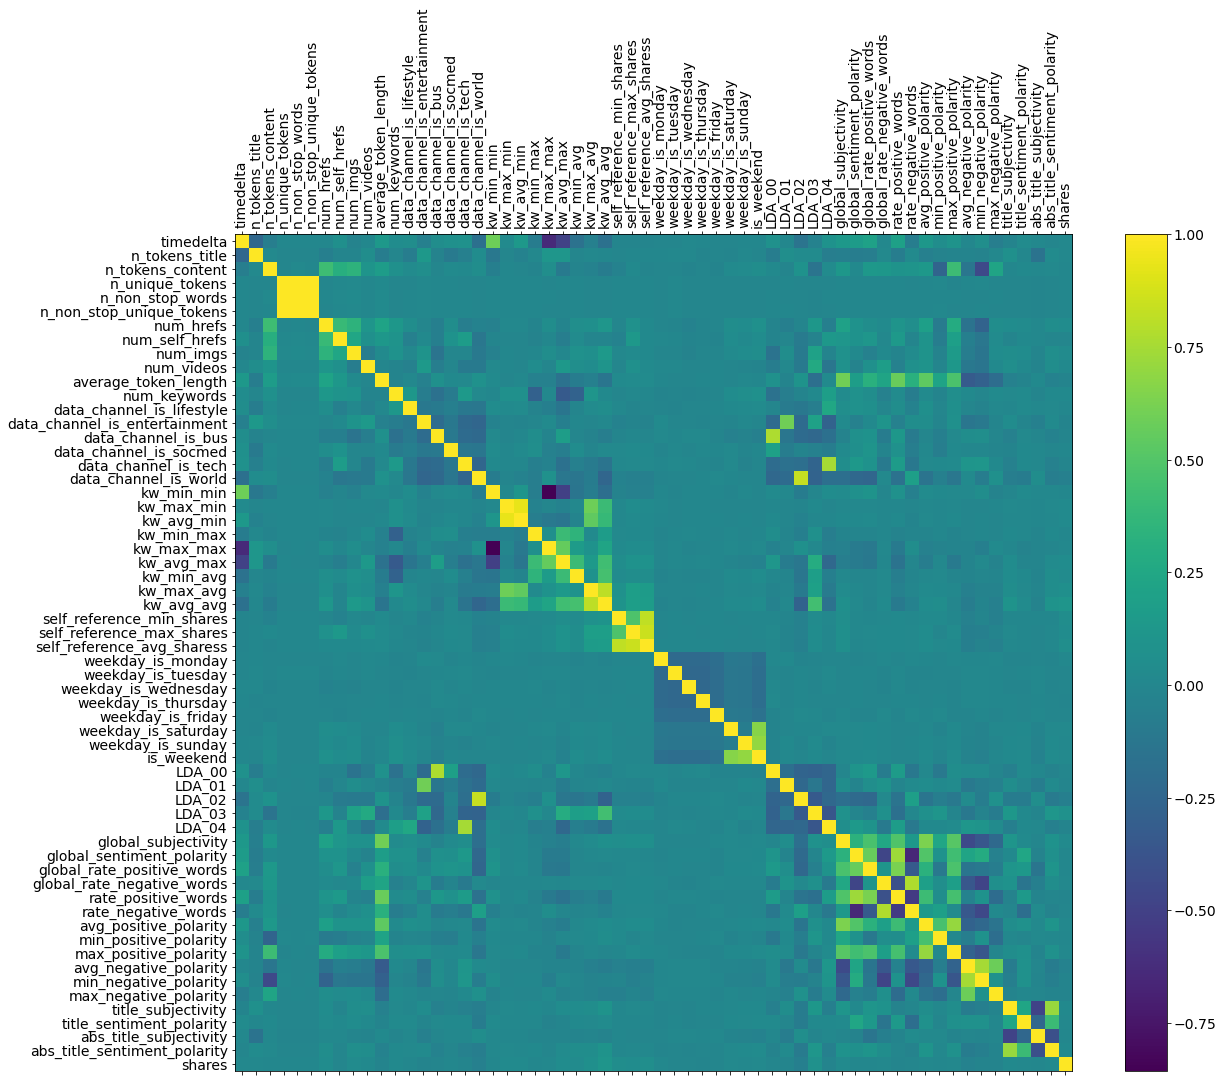

In [4]:
# Plot correlation matrix
f = plt.figure(figsize=(19,15))
plt.matshow(df_news.corr(), fignum=f.number)
plt.xticks(range(df_news.shape[1]), df_news.columns, fontsize=14, rotation=90)
plt.yticks(range(df_news.shape[1]), df_news.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [4]:
# Identify highly correlated variables
corrmat = pg.pairwise_corr(df_news, method='pearson')[['X', 'Y', 'r']]
df_corr = corrmat.sort_values(by='r', ascending=0)[(corrmat['r'] >= 0.85) | (corrmat['r'] <= -0.85)]
df_corr

,X,Y,r
175,n_unique_tokens,n_non_stop_unique_tokens,0.999852
174,n_unique_tokens,n_non_stop_words,0.999572
230,n_non_stop_words,n_non_stop_unique_tokens,0.999532
950,kw_max_min,kw_avg_min,0.940545
1274,self_reference_max_shares,self_reference_avg_sharess,0.853480
912,kw_min_min,kw_max_max,-0.857226


It appears that there are a few highly correlated variables (in absolute value). In order to make sure these variables won't introduce any redundancy or bias in our model, we will remove variables with high correlations or that seem redundant.

In [5]:
setcols = set(df_corr.Y.to_list())

# Drop columns high correlation values
df_news = df_news.drop(list(setcols), axis=1)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 55 columns):
timedelta                        39644 non-null float16
n_tokens_title                   39644 non-null float16
n_tokens_content                 39644 non-null float16
n_unique_tokens                  39644 non-null float16
num_hrefs                        39644 non-null float16
num_self_hrefs                   39644 non-null float16
num_imgs                         39644 non-null float16
num_videos                       39644 non-null float16
average_token_length             39644 non-null float16
num_keywords                     39644 non-null float16
data_channel_is_lifestyle        39644 non-null float16
data_channel_is_entertainment    39644 non-null float16
data_channel_is_bus              39644 non-null float16
data_channel_is_socmed           39644 non-null float16
data_channel_is_tech             39644 non-null float16
data_channel_is_world            39644 non-null flo

## EDA & Feature Engineering

### Number of shares by number of images

Text(0.5, 1.0, 'Number of shares by number of images for all data')

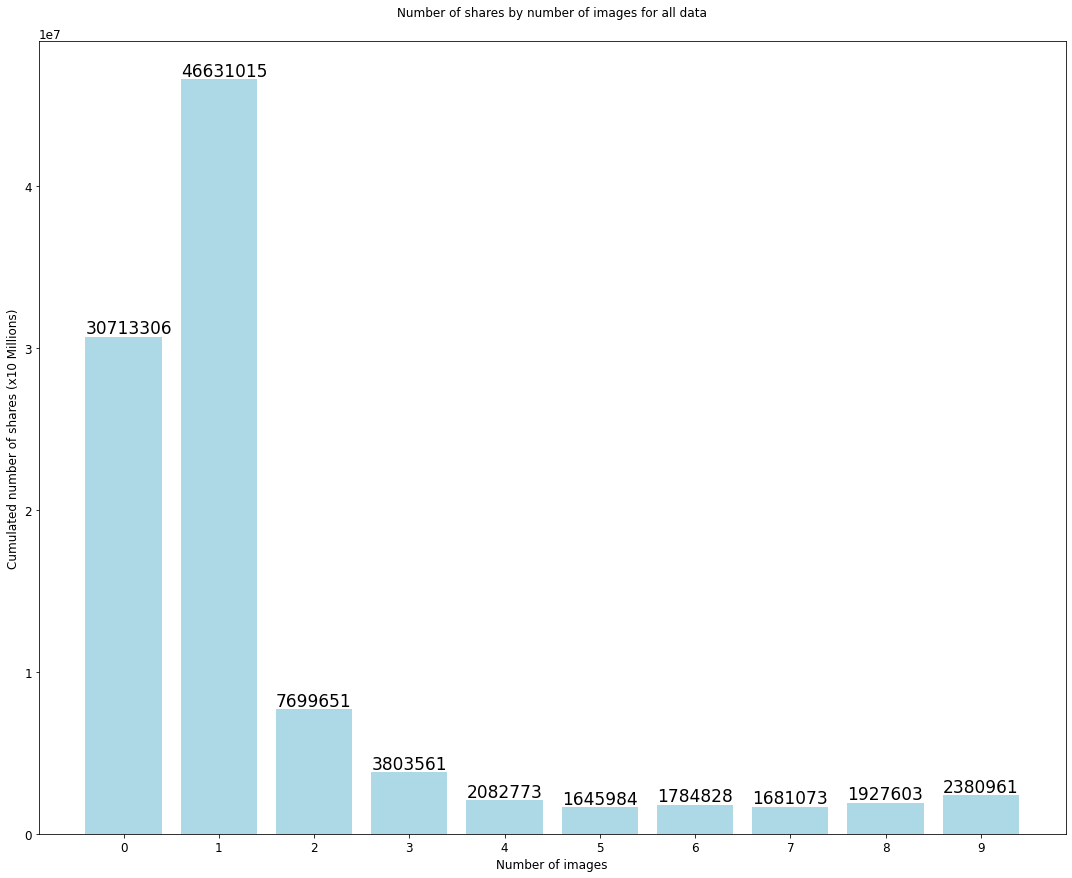

In [7]:
size=12
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.subplots(figsize =(15, 12))
both = list(zip(df_news["shares"].copy(),df_news["num_imgs"].copy()))
liste = [0,0,0,0,0,0,0,0,0,0]
for element in both:
    if (element[1] < 10):
        liste[int(element[1])] += element[0]
plt.bar(np.array([f'{i}' for i in range(10)]),liste,color='lightblue') 
plt.xlabel('Number of images')
plt.ylabel('Cumulated number of shares (x10 Millions)')
for index,data in enumerate(liste):
    plt.text(x=index-0.4 , y =data+200000 , s=f"{data}" , fontdict=dict(fontsize=17))
plt.tight_layout()
plt.title('Number of shares by number of images for all data')

 Only having 1 image seems to be the sweet spot when it comes to the popularity of articles.

### Number of shares by number of videos

Text(0.5, 1.0, 'Number of shares by number of videos for all data')

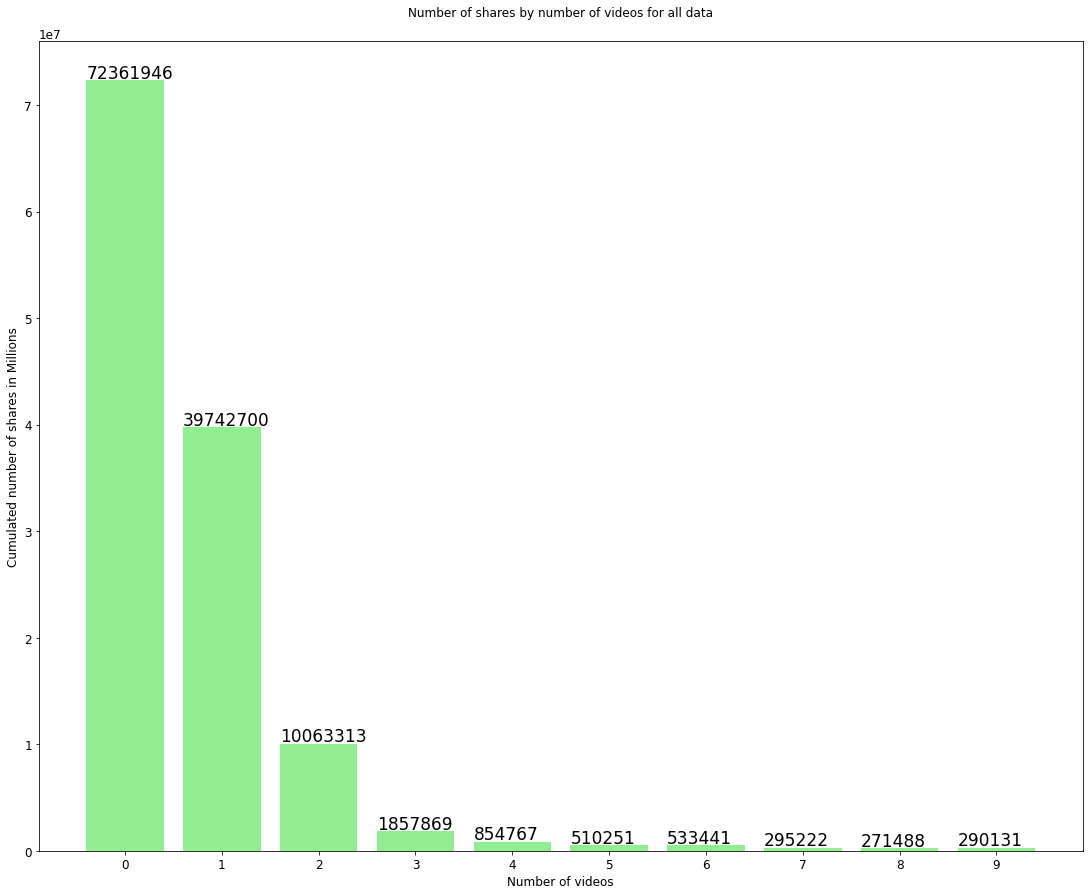

In [8]:
plt.subplots(figsize =(15, 12))
both = list(zip(df_news["shares"].copy(),df_news["num_videos"].copy()))
liste = [0,0,0,0,0,0,0,0,0,0]
for element in both:
    if (element[1] < 10):
        liste[int(element[1])] += element[0]
plt.bar(np.array([f'{i}' for i in range(10)]),liste ,color='lightgreen')
for index,data in enumerate(liste):
    plt.text(x=index-0.4 , y =data+200000 , s=f"{data}" , fontdict=dict(fontsize=17))
plt.tight_layout()
plt.xlabel('Number of videos')
plt.ylabel('Cumulated number of shares in Millions')
plt.title('Number of shares by number of videos for all data')

Not having any video in your article seems to be a better choice to increase the chance of the chance to be shared.

### Number and proportion of popular and unpopular news by day

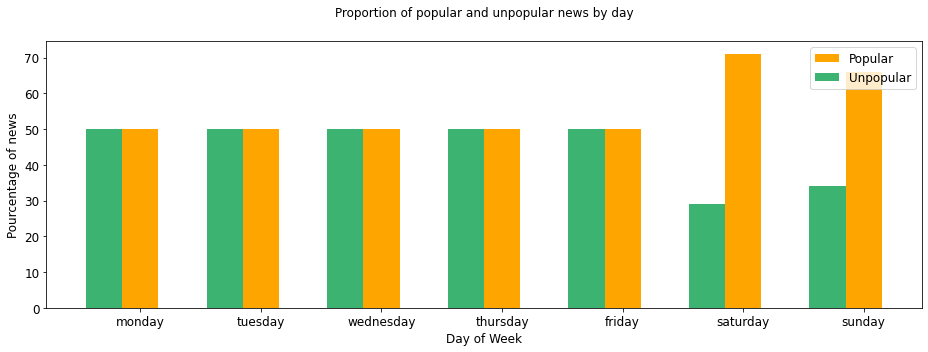

In [9]:
dayz = [col for col in df_news if col.startswith('weekday')]
days = []
for day in dayz:
    days.append(day[11:])
unpopular = df_news[df_news['shares'] <= 1400]
popular = df_news[df_news['shares']>= 1400]
unpop_day = unpopular[dayz].sum().values
pop_day = popular[dayz].sum().values
propun = []
proppop = []
for col in range(7):
    propun.append(round((unpop_day[col]/(pop_day[col] + unpop_day[col]))*100))
    proppop.append(round((pop_day[col]/(pop_day[col] + unpop_day[col]))*100))

fig = plt.figure(figsize = (13,5))
plt.title("Proportion of popular and unpopular news by day")

plt.bar(np.arange(len(days)),proppop,width=0.3,align='center',color='orange',label='Popular')
plt.bar(np.arange(len(days))-0.3,propun,width=0.3,align='center',color='mediumseagreen',label='Unpopular')

plt.xticks(np.arange(len(days)),days)
plt.ylabel('Pourcentage of news')
plt.xlabel('Day of Week')


plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

People seem to share a lot more on the weekend.

### Number and proportion of popular/unpopular news by data channel

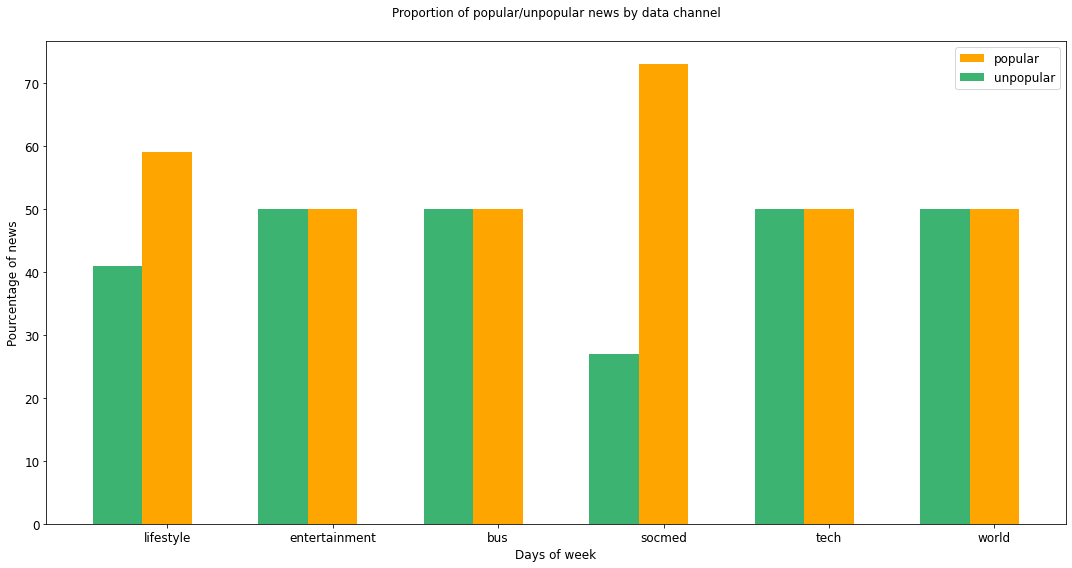

In [10]:
channelz = [col for col in df_news if col.startswith('data_channel')]
channels = []
for channel in channelz:
    channels.append(channel[16:])

unpop = unpopular[channelz].sum().values
pop = popular[channelz].sum().values
propun = []
proppop =[]
for col in range(6):
    propun.append(round((unpop[col]/(pop[col] + unpop[col]))*100))
    proppop.append(round((pop[col]/(pop[col] + unpop[col]))*100))


fig = plt.figure(figsize = (15,8))
plt.title("Proportion of popular/unpopular news by data channel")
plt.bar(np.arange(len(channels)), proppop, width = 0.3, align="center", color = 'orange', \
          label = "popular")
plt.bar(np.arange(len(channels)) - 0.3, propun, width = 0.3, align = "center", color = 'mediumseagreen', \
          label = "unpopular")
plt.xticks(np.arange(len(channels)), channels)
plt.ylabel("Pourcentage of news")
plt.xlabel("Days of week")
    
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

Articles published in lifestyle, social media and tech have more chance of being liked and shares

## Data modelisation

First, I need to decide on the cutoff to generate a binary label indicating whether a news is popular or not (`1` being popular, `0` otherwise). With the median value for # of shares - 1400, it will be used to create our binary target.

Then, I need to have a train/test split of the dataset. Because the dataset is __time-series__, we use the earlier 70% as our training set and the latest 30% as our test set to prevent time overlap between training and test sets.
Finally, we need to scale the features before modeling. In our case, we use a `MinMax` scaler to scale each numerical feature to $\{0,1\}$ range.

In [6]:
# label the dataframe
df_news['label']=[1 if x >= 1400 else 0 for x in df_news['shares']]
df_news = df_news.drop(['shares', 'timedelta'], axis=1)

# Encoding categorical data
y = df_news['label'].values
labelencoder = LabelEncoder()
df_news['label'] = labelencoder.fit_transform(y)

col_list = [s for s in df_news.columns if 'is' in s]
df_news[col_list] = df_news[col_list].apply(lambda x: labelencoder.fit_transform(x))

In [7]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 54 columns):
n_tokens_title                   39644 non-null float16
n_tokens_content                 39644 non-null float16
n_unique_tokens                  39644 non-null float16
num_hrefs                        39644 non-null float16
num_self_hrefs                   39644 non-null float16
num_imgs                         39644 non-null float16
num_videos                       39644 non-null float16
average_token_length             39644 non-null float16
num_keywords                     39644 non-null float16
data_channel_is_lifestyle        39644 non-null int64
data_channel_is_entertainment    39644 non-null int64
data_channel_is_bus              39644 non-null int64
data_channel_is_socmed           39644 non-null int64
data_channel_is_tech             39644 non-null int64
data_channel_is_world            39644 non-null int64
kw_min_min                       39644 non-null float16
kw_max_

I could determine a **base rate** using simple heuristic method. This base rate would be predicting all the `1`hence giving us a base rate accuracy:

In [17]:
print('base rate | accuracy:',sum(y)/len(y))

base rate | accuracy: 0.5335990313792756


#### Scaling numerical data

In [8]:
col_list = [s for s in df_news.columns if 'is' in s] + ['label']

# Scaling numerical data
from sklearn.preprocessing import MinMaxScaler
num_cols = [m for m in df_news if m not in col_list]
scale = MinMaxScaler()
df_news[num_cols] = pd.DataFrame(scale.fit_transform(df_news[num_cols].values), \
                                 columns=[num_cols], index=df_news.index)
    
display(df_news.head())

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,label
0,0.476191,0.025850,0.000947,0.013158,0.017241,0.007812,0.0,0.582119,0.444444,0,...,0.099976,0.700195,0.649902,0.399902,0.800049,0.50000,0.406250,0.000000,0.187500,0
1,0.333333,0.030099,0.000863,0.009868,0.008621,0.007812,0.0,0.611273,0.333333,0,...,0.033325,0.700195,0.881226,0.875000,0.900024,0.00000,0.500000,1.000000,0.000000,0
2,0.333333,0.024906,0.000821,0.009868,0.008621,0.007812,0.0,0.546647,0.555556,0,...,0.099976,1.000000,0.533447,0.200195,0.866699,0.00000,0.500000,1.000000,0.000000,1
3,0.333333,0.062677,0.000719,0.029605,0.000000,0.007812,0.0,0.548105,0.666667,0,...,0.136353,0.799805,0.630371,0.399902,0.833374,0.00000,0.500000,1.000000,0.000000,0
4,0.523810,0.126534,0.000593,0.062500,0.163793,0.156250,0.0,0.582604,0.666667,0,...,0.033325,1.000000,0.779785,0.500000,0.950012,0.45459,0.568176,0.090881,0.136353,0


### Automated feature selection with Boruta

`Boruta` is an algorithm designed to solve the infamous problem of finding a subset of features from the dataset which are relevant to given classification task. It finds relevant features by comparing original attributes' importance with importance achievable at random, estimated using their permuted copies (shadows).

We will be using a `RandomForestClassifier` classifier to be used with `Boruta`

In [9]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy


X = df_news.drop(['label'], axis=1)
Y = df_news['label']

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth = 3)
forest.fit(X, Y)

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=0, random_state=1)

# find all relevant features
feat_selector.fit(X.values, Y.values)

# check selected features
print(feat_selector.support_)

# check ranking of features
print(feat_selector.ranking_) #Rank 1 is the best
feature_names = np.array(X.columns)

# zip feature names, ranks, and decisions 
feature_ranks = list(zip(feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# print the results
for feat in feature_ranks:
    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True]
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 2 1 4 6 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1]
Feature: n_tokens_title                 Rank: 1,  Keep: True
Feature: n_tokens_content               Rank: 1,  Keep: True
Feature: n_unique_tokens                Rank: 1,  Keep: True
Feature: num_hrefs                      Rank: 1,  Keep: True
Feature: num_self_hrefs                 Rank: 1,  Keep: True
Feature: num_imgs                       Rank: 1,  Keep: True
Feature: num_videos                     Rank: 1,  Keep: True
Feature: average_token_length           Rank: 1,  Keep: True
Feature: num_keywords                   Rank: 1,  Keep: True
Feature: data_chan

Now that we have identified the features to drop, we can confidently drop them and proceed with our normal routine.

In [10]:
keep_cols = list(X.columns[feat_selector.support_]) + ['label']
keep_cols

['n_tokens_title',
 'n_tokens_content',
 'n_unique_tokens',
 'num_hrefs',
 'num_self_hrefs',
 'num_imgs',
 'num_videos',
 'average_token_length',
 'num_keywords',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'kw_min_min',
 'kw_max_min',
 'kw_min_max',
 'kw_avg_max',
 'kw_min_avg',
 'kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'weekday_is_wednesday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'rate_positive_words',
 'rate_negative_words',
 'avg_positive_polarity',
 'min_positive_polarity',
 'max_positive_polarity',
 'avg_negative_polarity',
 'min_negative_polarity',
 'max_negative_polarity',
 'title_subjectivity',
 'title_sentiment_polarity',
 'abs_title_sentiment_p

In [11]:
df_news_filtered = df_news[keep_cols]

m, k = df_news_filtered.shape
print("{} x {} table of data:".format(m, k))
display(df_news_filtered.head())
print("...")

39644 x 48 table of data:


,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_entertainment,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity,label
0,0.476191,0.025850,0.000947,0.013158,0.017241,0.007812,0.0,0.582119,0.444444,1,...,0.378662,0.099976,0.700195,0.649902,0.399902,0.800049,0.50000,0.406250,0.187500,0
1,0.333333,0.030099,0.000863,0.009868,0.008621,0.007812,0.0,0.611273,0.333333,0,...,0.286865,0.033325,0.700195,0.881226,0.875000,0.900024,0.00000,0.500000,0.000000,0
2,0.333333,0.024906,0.000821,0.009868,0.008621,0.007812,0.0,0.546647,0.555556,0,...,0.495850,0.099976,1.000000,0.533447,0.200195,0.866699,0.00000,0.500000,0.000000,1
3,0.333333,0.062677,0.000719,0.029605,0.000000,0.007812,0.0,0.548105,0.666667,1,...,0.385986,0.136353,0.799805,0.630371,0.399902,0.833374,0.00000,0.500000,0.000000,0
4,0.523810,0.126534,0.000593,0.062500,0.163793,0.156250,0.0,0.582604,0.666667,0,...,0.411133,0.033325,1.000000,0.779785,0.500000,0.950012,0.45459,0.568176,0.136353,0


...


In [12]:
# train/test split (70/30)
X = df_news_filtered.drop('label', axis=1)
y = df_news_filtered.pop('label')
# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 100)

m, k = X_train.shape
print("{} x {} table of data:".format(m, k))
display(X_train.head())
print("...")

31715 x 47 table of data:


,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_entertainment,...,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity
38512,0.380952,0.092068,0.000695,0.023026,0.008621,0.007812,0.000000,0.555879,1.000000,0,...,0.090881,0.384277,0.099976,0.899902,0.911133,0.833374,0.950012,0.000000,0.500000,0.000000
825,0.285714,0.224032,0.000536,0.052632,0.034483,0.007812,0.000000,0.595724,0.666667,0,...,0.365479,0.373291,0.033325,1.000000,0.806885,0.600098,0.975006,0.500000,0.568176,0.136353
2457,0.380952,0.026558,0.000857,0.006579,0.000000,0.007812,0.000000,0.562196,0.333333,0,...,0.000000,0.324219,0.099976,0.600098,1.000000,1.000000,1.000000,0.500000,0.500000,0.000000
21858,0.238095,0.012512,0.001090,0.016447,0.017241,0.000000,0.010989,0.652575,0.555556,0,...,0.285645,0.377197,0.136353,0.500000,0.574951,0.399902,0.750000,0.300049,1.000000,1.000000
12372,0.571429,0.083805,0.000638,0.013158,0.025862,0.093750,0.000000,0.500000,0.444444,0,...,0.196045,0.376465,0.099976,1.000000,0.738281,0.299805,0.900024,0.427246,0.634033,0.268066


...


In [13]:
y_train.head()

38512    1
825      1
2457     1
21858    0
12372    1
Name: label, dtype: int64

In [14]:
params = {
    "objective": "binary",
    "num_leaves": 10,
    "min_data_in_leaf": 50,
    "learning_rate": 0.001,
    "feature_fraction": 1.0,
    "bagging_fraction": 1.0,
    "bagging_freq": 1,
    "max_depth":20
}
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.001, max_depth=20,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=50, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [16]:
y_pred=clf.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.5336


### Testing `train.py`

Let's try to run the `train.py` script in command line.

In [18]:
%run -t train.py --num-leaves 10 --min-data-in-leaf 50 --learning-rate 0.001 --feature-fraction 1.0 --bagging-fraction 1.0 --bagging-freq 1 --max-depth 20

azureml.core.VERSION=1.23.0
Namespace(bagging_fraction=1.0, bagging_freq=1, feature_fraction=1.0, learning_rate=0.001, max_depth=20, min_data_in_leaf=50, num_leaves=10)
{'objective': 'binary', 'num_leaves': 10, 'min_data_in_leaf': 50, 'learning_rate': 0.001, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'num_threads': 16, 'max_depth': 20}
Loading data from https://github.com/franckess/AzureML_Capstone/blob/main/data/OnlineNewsPopularity.csv?raw=true
Running pre-processing steps
Loading Boruta model for feature selection from https://github.com/franckess/AzureML_Capstone/releases/download/1.1/boruta_model_final.pkl
Running modeling step
LightGBM Model accuracy score: 0.5336
Attempted to log scalar metric Accuracy:
0.533610795812839

IPython CPU timings (estimated):
  User   :     107.85 s.
  System :       9.91 s.
Wall time:      16.43 s.


## Export model

In [36]:
import os
import joblib

os.makedirs("./output/", exist_ok=True)
# Save Boruta model
model_path = os.path.join("./output/", 'boruta_model_final.pkl')
joblib.dump(feat_selector, model_path)

['./output/boruta_model_final.pkl']